## Group 14C - Fake News Detector Project (Logistic Regression Model Test - Nina)

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


#### Step 1: Data Preparation

In [2]:
import pandas as pd
from pathlib import Path

import re
import nltk
from nltk.corpus import stopwords
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt                     # plotting

from sklearn.metrics import (
    roc_curve,      # → returns fpr, tpr, thresholds
    auc,            # → scalar area-under-curve
    RocCurveDisplay # → convenience display helper (sk-learn ≥ 1.0)
)
# if you just want the number, not the curve
from sklearn.metrics import roc_auc_score

In [3]:
# Fake News Dataset with Label (0 for Fake)
df_fake = pd.read_csv(Path("Dataset") / "Fake.csv")
df_fake['label'] = 0 

# True News Dataset with Label (1 for True)
df_true = pd.read_csv(Path("Dataset") / "True.csv")
df_true['label'] = 1

# Combine Datasets
cols = ['title', 'text', 'label']
df = pd.concat([df_fake[cols], df_true[cols]], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/Fake.csv'

#### Step 2: Text Preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower()) # Remove punctuation and lowercase
    words = text.split() # Tokenization
    words = [w for w in words if w not in stop_words] # Remove stopwords
    return ' '.join(words) # Rejoin words

df['cleaned_text'] = df['text'].apply(preprocess_text)


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/rhodesanchez/nltk_data'
    - '/Users/rhodesanchez/fakeornah/.venv/nltk_data'
    - '/Users/rhodesanchez/fakeornah/.venv/share/nltk_data'
    - '/Users/rhodesanchez/fakeornah/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


#### Step 3: Feature Extraction

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) # Vectorizes Text Data
x = vectorizer.fit_transform(df['cleaned_text']) # Assigns text data to x
y = df['label'] # Assigns labels to y

#### Step 4: Train-Test Split (70-30)

In [ ]:
# Train-Test Split (70-30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#### Step 5: Train Logistic Regression Model

In [ ]:
clf = LogisticRegression(max_iter=1_000, n_jobs=-1)
clf.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### Step 6: Evaluate the Model

In [ ]:
y_pred = clf.predict(x_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n",   confusion_matrix(y_test, y_pred))

Accuracy : 0.9899777282850779

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7091
           1       0.99      0.99      0.99      6379

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470


Confusion matrix:
 [[7013   78]
 [  57 6322]]


#### Step 7: Visualizations

/Users/ninaelmoyan/fakeornah/.venv/lib/python3.13/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


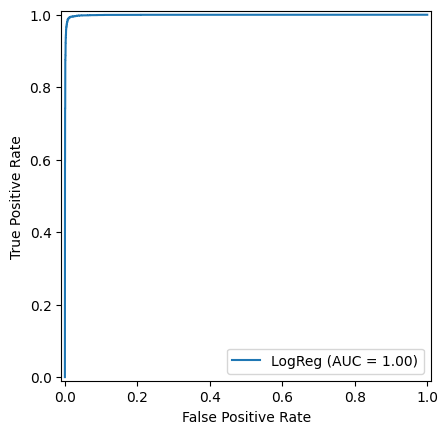

In [ ]:
y_prob = clf.predict_proba(x_test)[:,1]           # probability of class 1
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name='LogReg').plot()
plt.show()

##STEP 8 XGBOOST RHODE


In [ ]:
##STEP 8
# ==== XGBoost Classifier – Rhode ====

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XGBoost model
xgb_clf = XGBClassifier(
    n_estimators=300,          # number of trees
    learning_rate=0.1,        # how fast it learns
    max_depth=6,              # depth of each tree
    subsample=0.9,            # use 90% of rows per tree
    colsample_bytree=0.9,     # use 90% of features per tree
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1                 # use all cores
)

# Train on the same training data
xgb_clf.fit(x_train, y_train)

# Predictions (class labels: 0 = fake, 1 = real)
y_pred_xgb = xgb_clf.predict(x_test)

# Prediction probabilities (needed for ROC curve)
y_prob_xgb = xgb_clf.predict_proba(x_test)[:, 1]

print("=== XGBoost Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – XGBoost')
plt.legend(loc='lower right')
plt.show()



XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/rhodesanchez/fakeornah/.venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <B111F8D5-6AC6-3245-A6B5-94693F6992AB> /Users/rhodesanchez/fakeornah/.venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]
